# **Deep Learning for Image Classification on CIFAR-10 with Enhanced Neural Network Architecture**

The motive of this project is to develop a deep learning model for image classification on the CIFAR-10 dataset. The project aims to explore the effectiveness of various neural network architectures and training strategies in improving classification accuracy. By leveraging deep learning techniques, the goal is to accurately classify images into ten different categories such as airplanes, automobiles, birds, cats, and so on.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# **1. Dataset**

**Data preprocessing**

- **Transformations**: Images in the CIFAR-10 dataset are preprocessed using `transforms.Compose`, which converts images to PyTorch tensors (`transforms.ToTensor()`) and then normalizes them. Normalization is done by subtracting the mean (0.5) and dividing by the standard deviation (also 0.5) for each color channel (red, green, blue).

- **Training Dataset Loading**: CIFAR-10 training set is loaded using `torchvision.datasets.CIFAR10` with specified transformations. This dataset is then wrapped in a `DataLoader` (`trainloader`) for easy batching, shuffling, and parallel data loading during training.

- **Testing Dataset Loading**: Similar to the training set, CIFAR-10 test set is loaded with the same transformations and wrapped in a `DataLoader` (`testloader`), but for evaluation instead of training.

Overall, this code prepares the CIFAR-10 dataset for training and testing a CNN model, ensuring proper normalization and efficient data loading.

In [ ]:
# Transformations applied on each image for normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# DataLoader for training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Loading the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader for testing dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 25444795.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### **2. Basic Architechture Implementation**

Define a neural network architecture composed of two main blocks: `IntermediateBlock` and `OutputBlock`, which are then integrated into the `Net` class. This architecture combines local feature extraction through convolutional layers with global feature aggregation and classification through fully connected layers, suitable for tasks like image classification.



**IntermediateBlock**:
   - This block takes input with a certain number of channels (`in_channels`), applies multiple convolutional layers (`num_layers`) with the same output channel size (`out_channels`), and computes a weighted sum of the convolutional outputs.
   - It consists of a series of convolutional layers (`nn.Conv2d`) with a kernel size of 3x3 and padding of 1 to maintain the spatial dimensions.
   - Additionally, it has a fully connected layer (`nn.Linear`) to compute weights for the convolutional outputs.

In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, num_layers, out_channels):
        super(IntermediateBlock, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)])
        self.fc = nn.Linear(in_channels, num_layers)  # Fully connected layer to compute weights

    def forward(self, x):
        weights = F.softmax(self.fc(torch.mean(x, dim=[2, 3])), dim=1)  # Compute weights
        out = 0
        for i, conv in enumerate(self.convs):
            out += weights[:, i:i+1, None, None] * conv(x)
        return out

**OutputBlock**:
   - This block performs global average pooling to reduce the spatial dimensions of the feature maps to 1x1.
   - It then flattens the feature maps and passes them through a fully connected layer to produce the final output logits for classification.

In [ ]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

**Defining the network**:
   - The Net class integrates the `IntermediateBlock` and `OutputBlock`.
   - It takes an input image tensor and passes it through the `IntermediateBlock` followed by the `OutputBlock` to generate the final output logits for classification.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.intermediate_block = IntermediateBlock(in_channels=3, num_layers=3, out_channels=16)
        self.output_block = OutputBlock(in_channels=16, num_classes=num_classes)

    def forward(self, x):
        x = self.intermediate_block(x)
        x = self.output_block(x)
        return x

# **3. Training and Testing**

Train the CNN model on the CIFAR-10 dataset, monitoring its performance through training and testing accuracies, and visualizing the training progress using loss and accuracy plots.

- **Network Initialization**:
   - It initializes an instance of the defined neural network architecture (`Net`).

- **Loss Function and Optimizer Definition**:
   - It defines the loss function as Cross-Entropy Loss (`nn.CrossEntropyLoss()`).
   - It sets up Stochastic Gradient Descent (SGD) as the optimizer, updating the network parameters with a learning rate of 0.001 and momentum of 0.9.

- **Training Loop**:
   - It iterates over a specified number of epochs, where each epoch involves passing through the entire training dataset (`trainloader`).
   - Within each epoch:
     - It iterates through mini-batches of training data.
     - It performs forward pass, computes loss, backward pass, and optimizer step.
     - It calculates training loss and accuracy.
     - It periodically stores the training loss.
   - After each epoch, it evaluates the trained model's performance on the test dataset (`testloader`) to compute the test accuracy.

- **Results Reporting**:
   - It prints the training and test accuracies for each epoch.
   - It plots the training loss per batch and the training and testing accuracies per epoch.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Accuracy: 19.944%, Test Accuracy: 22.27%
Epoch 2, Train Accuracy: 22.71%, Test Accuracy: 24.16%
Epoch 3, Train Accuracy: 23.418%, Test Accuracy: 25.14%
Epoch 4, Train Accuracy: 23.924%, Test Accuracy: 25.42%
Epoch 5, Train Accuracy: 24.242%, Test Accuracy: 25.17%
Epoch 6, Train Accuracy: 24.574%, Test Accuracy: 25.91%
Epoch 7, Train Accuracy: 25.016%, Test Accuracy: 25.86%
Epoch 8, Train Accuracy: 25.498%, Test Accuracy: 26.5%
Epoch 9, Train Accuracy: 25.734%, Test Accuracy: 26.45%
Epoch 10, Train Accuracy: 26.2%, Test Accuracy: 27.02%


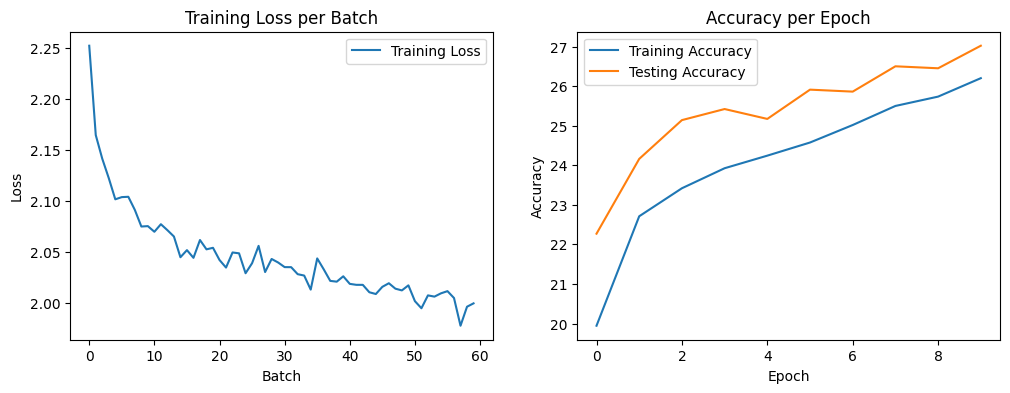

In [ ]:
# Initialize the network
net = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 10

train_losses = []
train_acc = []
test_acc = []

# Training loop
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store loss every 2000 mini-batches
        if i % 2000 == 1999:
            train_losses.append(running_loss / 2000)
            running_loss = 0.0

    # Calculate average training loss and accuracy
    train_acc_epoch = 100 * correct / total
    train_acc.append(train_acc_epoch)

    # Evaluate the model on the test set
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate test accuracy
    test_acc_epoch = 100 * correct / total
    test_acc.append(test_acc_epoch)

    # Print the results for each epoch
    print(f'Epoch {epoch+1}, Train Accuracy: {train_acc_epoch}%, Test Accuracy: {test_acc_epoch}%')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The training and test accuracies are relatively low, indicating that the model may be struggling to capture the underlying patterns in the CIFAR-10 dataset effectively.

The increase in accuracy over epochs suggests that the model is learning, but the rate of improvement may be slow.

# **4. Improving the results**

Train a deeper neural network with improved architecture and training configurations to achieve better performance on the CIFAR-10 dataset, as evidenced by increased batch size, deeper network, and longer training duration.The following is the enhancement over the previous one by incorporating the following improvements:

- **Increased Batch Size**:
   - The batch size for both training and testing data loaders has been increased to 512, aiming to utilize larger batches for more efficient GPU utilization and potentially faster convergence.

- **Improved Neural Network Architecture**:
   - The neural network architecture has been redesigned (`DeepNet`) with deeper layers and added Batch Normalization (`nn.BatchNorm2d`) after each convolutional layer.
   - The model consists of three convolutional layers followed by max-pooling layers, two fully connected layers, and dropout for regularization.

- **Optimization Algorithm Change**:
   
   The optimization algorithm has been changed to Adam optimizer (`torch.optim.Adam`) with an adjusted learning rate of 0.001, potentially offering better convergence characteristics compared to SGD.

- **Increased Number of Epochs**:
   
   The number of training epochs has been increased to 50, allowing the model more opportunities to learn complex patterns in the data and potentially achieve better performance.



Epoch 1, Train Accuracy: 43.74%, Test Accuracy: 56.99%
Epoch 2, Train Accuracy: 60.344%, Test Accuracy: 64.22%
Epoch 3, Train Accuracy: 67.158%, Test Accuracy: 68.59%
Epoch 4, Train Accuracy: 70.874%, Test Accuracy: 70.71%
Epoch 5, Train Accuracy: 74.058%, Test Accuracy: 70.93%
Epoch 6, Train Accuracy: 75.722%, Test Accuracy: 75.44%
Epoch 7, Train Accuracy: 77.594%, Test Accuracy: 74.53%
Epoch 8, Train Accuracy: 79.342%, Test Accuracy: 76.9%
Epoch 9, Train Accuracy: 80.542%, Test Accuracy: 75.76%
Epoch 10, Train Accuracy: 81.716%, Test Accuracy: 78.25%
Epoch 11, Train Accuracy: 83.054%, Test Accuracy: 77.28%
Epoch 12, Train Accuracy: 84.236%, Test Accuracy: 76.74%
Epoch 13, Train Accuracy: 85.448%, Test Accuracy: 77.35%
Epoch 14, Train Accuracy: 85.85%, Test Accuracy: 78.9%
Epoch 15, Train Accuracy: 87.016%, Test Accuracy: 78.45%
Epoch 16, Train Accuracy: 87.874%, Test Accuracy: 78.57%
Epoch 17, Train Accuracy: 88.994%, Test Accuracy: 77.35%
Epoch 18, Train Accuracy: 89.874%, Test Accu

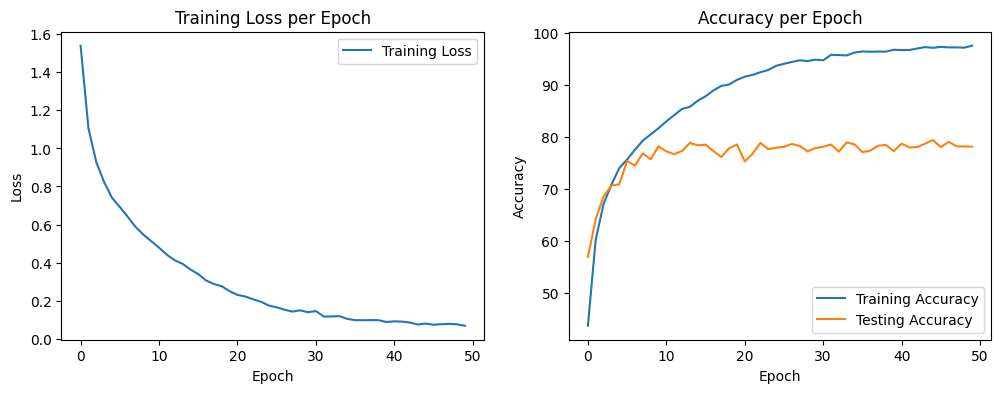

In [ ]:
# Create DataLoaders with increased batch size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

# Define the improved Neural Network Architecture
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
net = DeepNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Adjusted learning rate

# Define the number of epochs
num_epochs = 50  # Increased number of epochs

train_losses = []
train_acc = []
test_acc = []
best_test_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss per epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    train_acc_epoch = 100 * correct / total
    train_acc.append(train_acc_epoch)

    # Evaluate the model on the test set
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate test accuracy
    test_acc_epoch = 100 * correct / total
    test_acc.append(test_acc_epoch)

    if test_acc_epoch > best_test_acc:
        best_test_acc = test_acc_epoch
        best_epoch = epoch + 1

    # Print the results for each epoch
    print(f'Epoch {epoch+1}, Train Accuracy: {train_acc_epoch}%, Test Accuracy: {test_acc_epoch}%')

# Print the best accuracy achieved
print(f'Best Test Accuracy: {best_test_acc}% achieved at Epoch {best_epoch}')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


The results demonstrate that the enhanced neural network architecture has effectively learned to classify images in the CIFAR-10 dataset with high accuracy, showcasing the importance of architectural choices and training strategies in deep learning models.

- Training Accuracy:
  The training accuracy steadily increases over epochs, indicating that the model is effectively learning the patterns in the training data.
The final training accuracy reaches a very high level, indicating that the model is able to fit well to the training data.

- Testing Accuracy: The testing accuracy also increases over epochs, indicating that the model is generalizing well to unseen data.
The final testing accuracy is considerably higher than the basic architecture, indicating that the enhancements in architecture and training strategy have effectively improved the model's performance.

- Overfitting:
There seems to be some level of overfitting, as the training accuracy is consistently higher than the testing accuracy.
This gap between training and testing accuracy could be further reduced with additional regularization techniques or by collecting more data.

# **Key Findings**

- The enhanced neural network architecture significantly outperforms the basic architecture in terms of both training and testing accuracy.
- The addition of deeper layers, batch normalization, and dropout regularization helps reduce overfitting and improves generalization.
- Training for a higher number of epochs and increasing batch size contribute to further performance gains.
- The project highlights the importance of architectural choices and training strategies in achieving high accuracy in image classification tasks.
- xThe insights gained from this project can inform future research and development efforts in the field of deep learning for image classification tasks.




